In [8]:
#Choose a Dataset
#Use a pre-annotated dataset for object detection:
#COCO Dataset: Common Objects in Context (80 classes)
#Pascal VOC
#Custom dataset (optional) with annotations in YOLO or COCO format
#from ultralytics import YOLO #How to import a database
#pip install ultralytics


#Install Required Libraries
#pip install opencv-python matplotlib
#pip install tensorflow tensorflow-hub opencv-python matplotlib
#pip install tensorflow scikit-learn opencv-python gTTS




In [9]:
#Import Libraries
import os
import random
import requests
import torch
from PIL import Image
from torch.utils.data import DataLoader

from pathlib import Path

In [30]:
from super_gradients.training import models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from super_gradients.training import Trainer

from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, 
    coco_detection_yolo_format_val
)

from super_gradients.training.models.detection_models.pp_yolo_e import (
    PPYoloEPostPredictionCallback
)



In [27]:
#  Simple configuration class for creating the data set
class config:
    
    # Trainer params
    CHECKPOINT_DIR = '..//ipynb_checkpoints' # Saves checkpoints
    EXPERIMENT_NAME = 'race_number' # Name of the experiment
    
    # Dataset params
    DATA_DIR = './input' # The data directory
    
    # Training set
    TRAIN_IMAGES_DIR =  './train_images' # Train images folder
    TRAIN_LABELS_DIR = "./train_labels" # Train labels folder

    # Validation
    VAL_IMAGES_DIR = './val_images' # Validation images folder
    VAL_LABELS_DIR = './val_labels' # Validation labels folder (array of points)
    
    # Test set
    TEST_IMAGES_DIR = './test_images' #child dir of DATA_DIR where test images are
    TEST_LABELS_DIR = './test_labels' #child dir of DATA_DIR where test labels are (array of points)

    CLASSES = ['free_parking_space','not_free_parking_space','partially_free_parking_space']
    NUM_CLASSES = len(CLASSES)

    # Dataloader params
    DATALOADER_PARAMS={
    'batch_size': 4,
    'num_workers': 2
    }

    # Model params
    MODEL_NAME = "yolo_nas_l"
    CHECKPOINT_PATH = "model_checkpoints/hub/checkpoints/yolo_nas_l_coco.pth"



# Load your YOLO-NAS model manually with your checkpoint path
model = models.get(
    "yolo_nas_l",
    num_classes=config.NUM_CLASSES,
    checkpoint_path="model_checkpoints/hub/checkpoints/yolo_nas_l_coco.pth",
    load_backbone=True

)
#Test
# Set the model to evaluation mode
model.eval()



[2025-04-28 13:21:57] INFO - checkpoint_utils.py - Successfully loaded model's backbone weights from model_checkpoints/hub/checkpoints/yolo_nas_l_coco.pth checkpoint.


YoloNAS_L(
  (backbone): NStageBackbone(
    (stem): YoloNASStem(
      (conv): QARepVGGBlock(
        (nonlinearity): ReLU(inplace=True)
        (se): Identity()
        (branch_3x3): Sequential(
          (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        )
        (branch_1x1): Conv2d(3, 48, kernel_size=(1, 1), stride=(2, 2))
        (post_bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (rbr_reparam): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      )
    )
    (stage1): YoloNASStage(
      (downsample): QARepVGGBlock(
        (nonlinearity): ReLU(inplace=True)
        (se): Identity()
        (branch_3x3): Sequential(
          (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=Tr

In [28]:
# Test model with a dummy input
dummy_input = torch.randn(1, 3, 640, 640)

# Run the dummy input through the model
output = model(dummy_input)

print("Model output:", output)


Model output: ((tensor([[[-60.5887, -60.3306,  68.3902,  66.9769],
         [-52.7574, -60.0116,  76.6015,  66.9175],
         [-44.8122, -59.9077,  84.5920,  66.8594],
         ...,
         [302.0673, 367.3668, 817.4108, 879.8521],
         [334.0763, 367.3765, 849.4156, 879.8475],
         [366.0741, 367.3548, 881.4274, 879.8281]]], grad_fn=<MulBackward0>), tensor([[[0.0099, 0.0098, 0.0098],
         [0.0098, 0.0095, 0.0096],
         [0.0099, 0.0094, 0.0097],
         ...,
         [0.0100, 0.0100, 0.0100],
         [0.0100, 0.0100, 0.0100],
         [0.0100, 0.0100, 0.0100]]], grad_fn=<SigmoidBackward0>)), (tensor([[[-4.6046, -4.6182, -4.6178],
         [-4.6105, -4.6510, -4.6368],
         [-4.6043, -4.6617, -4.6217],
         ...,
         [-4.5952, -4.5967, -4.5957],
         [-4.5951, -4.5967, -4.5961],
         [-4.5953, -4.5968, -4.5956]]], grad_fn=<PermuteBackward0>), tensor([[[ 0.0079,  0.0542, -0.0723,  ..., -0.0304, -0.0212, -0.0927],
         [ 0.0430, -0.0066, -0.0654,

[2025-04-28 13:19:30] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 16/16 [00:00<00:00, 643.42it/s]
[2025-04-28 13:19:30] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 8/8 [00:00<00:00, 140.32it/s]
[2025-04-28 13:19:30] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 6/6 [00:00<00:00, 162.82it/s]


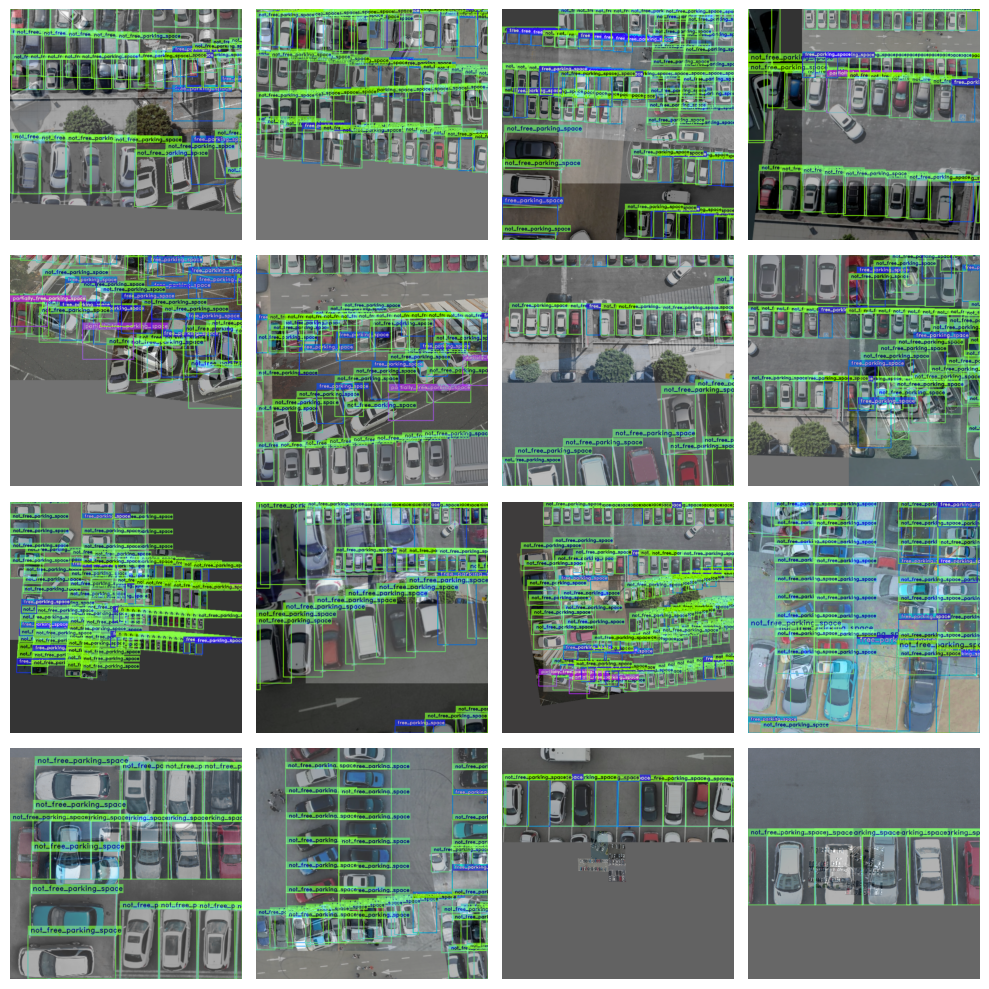

In [24]:
# Creating the dataset
# Split the datat into train, test, and validation sets
# The training dataset
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TRAIN_IMAGES_DIR,
        'labels_dir': config.TRAIN_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

# The validation data set
val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.VAL_IMAGES_DIR,
        'labels_dir': config.VAL_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

# The test data set
test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TEST_IMAGES_DIR,
        'labels_dir': config.TEST_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

train_data.dataset.plot() # Visualize the test images with plotting




In [76]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


In [35]:
# Create the trainer
trainer = Trainer(experiment_name=config.EXPERIMENT_NAME, ckpt_root_dir=config.CHECKPOINT_DIR)

# Define the training parameters
train_params = {
    # Basic settings
    "max_epochs": 50,              # You can adjust this
    "initial_lr": 5e-4,             # Start with a lower LR for fine-tuning
    "optimizer": "AdamW",           # Good optimizer for NAS models
    "zero_weight_decay_on_bias_and_bn": True,
    
    # Data
    "train_loader": train_data,
    "valid_loader": val_data,
    
    # Loss
    "loss": PPYoloELoss(
        num_classes=config.NUM_CLASSES,
        use_static_assigner=False
    ),

    # Metrics and Post-processing
    "metric_to_watch": "mAP@0.50",
    "valid_metrics_list": [DetectionMetrics_050(num_cls=config.NUM_CLASSES)],
    "loss_logging_items_names": ["total_loss", "cls_loss", "obj_loss", "iou_loss"],
    "post_prediction_callback": PPYoloEPostPredictionCallback(
    score_threshold=0.25,
    nms_threshold=0.7,
    nms_top_k=300,
    max_predictions=300),
    # Checkpointing
    "average_best_models": True,
    "save_best": True,
    "ckpt_best_name": "best_model.pth",
    "lr_mode": "cosine",          # Good for NAS
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "warmup_epochs": 3,
}

# Start training!
trainer.train(
    model=model,
    training_params=train_params,
    train_loader=train_data,
    valid_loader=val_data
)


[2025-04-28 13:40:15] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20250428_134015_864744`
[2025-04-28 13:40:15] INFO - sg_trainer.py - Checkpoints directory: ..//ipynb_checkpoints\race_number\RUN_20250428_134015_864744
c:\Users\hanna\anaconda3\envs\tf3\lib\site-packages\super_gradients\common\registry\registry.py:72: DeprecationWarning: Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
  warnings.warn(f"Object name `{name}` is now deprecated. Please replace it with `{deprecated_names[name]}`.", DeprecationWarning)
c:\Users\hanna\anaconda3\envs\tf3\lib\site-packages\super_gradients\training\utils\optimizer_utils.py:108: DeprecationWarning: initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 

The console stream is now moved to ..//ipynb_checkpoints\race_number\RUN_20250428_134015_864744/console_Apr28_13_40_15.txt


c:\Users\hanna\anaconda3\envs\tf3\lib\site-packages\psutil\_pswindows.py:274: DeprecationWarning: getargs: The 'u' format is deprecated. Use 'U' instead.
  total, free = cext.disk_usage(path)


KeyboardInterrupt: 